In [4]:
#hide
import sys
import numpy as np
import numpy.linalg as la
import scipy
from matplotlib import pyplot as plt, animation
import proplot as plot

plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['axes.grid'] = False
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'

In [5]:
#hide
sys.path.append('/Users/46h/Research/code/accphys')
from tools import plotting as myplt
from tools import animation as myanim

# Nonlinear resonances

- toc: true 
- badges: false
- comments: true
- categories: [physics, accelerators, nonlinear systems, resonances]

Most of us are familiar with the experience of pushing someone else on a playground swing. We intuitively know that we should sync our pushes with the swing oscillation frequency, which appears to be independent of the swing amplitude. This strategy employs the idea of a *resonance*, which is an increase of the oscillation amplitude of a system for certain driving frequencies. In this post we first review the mathematics of this simple example, then extend the machinery to the nonlinear dynamics in a particle accelerator. My goal here is to write down the main results which are relevant to accelerators in order to improve my own understanding of the topic.

![width=20](https://media.giphy.com/media/xT5LMs4OW7Oqdl8Uda/source.gif)

## Linear resonances

Consider a mass on a spring which, if left alone, oscillates at freqency $\omega_0^2$.

<img src=images_2021-03-28/oscillator.png width=400>

The equation of motion for $x$ is

$$\frac{d^2}{dt^2}{x} + \omega_0^2x = 0. \tag{1}$$

Now consider a sinusoidal driving force $f(t) = f_0 \cos(\omega t)$ as well as a damping term:

$$\frac{d^2}{dt^2}{x} + b\dot{x} + \omega_0^2x = f_0\cos(\omega t).$$

After doing some work it can be shown that the gravitational, damping, and driving forces initially fight against each other, but in the end the driving force dominates and the position oscillates as

$$ x(t) = A \cos(\omega t - \delta) \tag{2}$$

where 

$$A^2 = \frac{f_0^2}{(\omega - \omega_0)^2 + b\omega^2}. \tag{3}$$

The figure below shows the squared amplitude as the driving frequency is varied. The maximum amplitude approaches infinity as the damping term goes to zero.

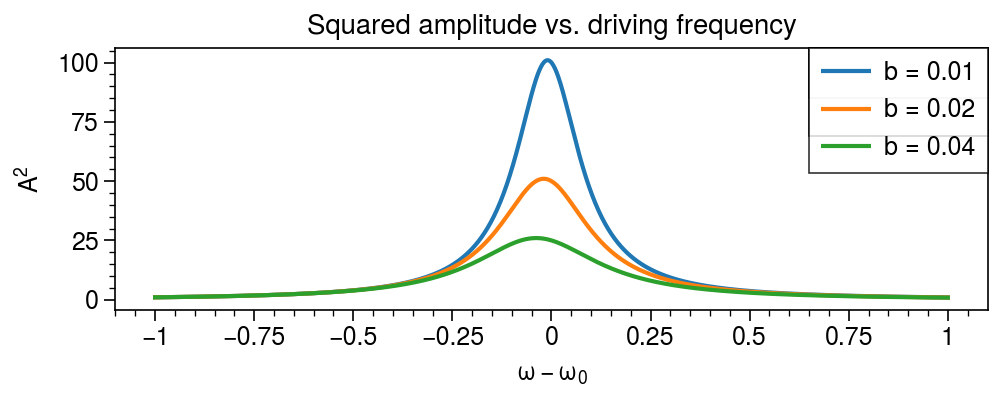

In [6]:
#hide_input
def get_amplitudes(f0, omegas, omega0, b):
    return f0**2 / ((omegas - omega0)**2 + b*omegas**2)

f0 = 1.0
omega0 = 1.0
damping_coeffs = omega0 * np.array([0.01, 0.02, 0.04])
omegas = np.linspace(0, 2, 1000)

fig, ax = plot.subplots(figsize=(5, 2))
for b in damping_coeffs:
    amplitudes = get_amplitudes(f0, omegas, omega0, b)
    ax.plot(omegas - omega0, amplitudes)
    ax.format(ylabel=r'$A^2$', xlabel=r'$\omega - \omega_0$', title='Squared amplitude vs. driving frequency')
    ax.legend(labels=['b = {}'.format(b) for b in damping_coeffs], ncols=1)

The next step is to consider what happens when the driving force is not a pure sine wave. We'll only consider periodic driving forces, and any periodic function can be written as a sum of sines and cosines of different frequencies. Assuming $f(t)$ is an even function so that we can drop the sine terms in the Fourier expansion, the equation of motion becomes

$$ \ddot{x} + b\dot{x} + \omega_0^2 x = \sum_{n=0}^{\infty} {f_n\cos(n \omega t)}. \tag{4}$$

The long-term solution is found by just adding up the solutions to each term in the sum:

$$x(t) = \sum_{n = 0}^{\infty}{A_n \cos{(n\omega t - \delta_n)}}, \tag{5}$$

where $A_n$ is given by Eq. (3) for the frequency $n\omega$. The resonance condition will apply to each of these amplitudes individually, which means that a resonance could be excited if any component of the driving force is near the natural frequency.

## Sources of nonlinearity

We're now going to apply these ideas to a particle accelerator. We'll assume small transverse oscillations, no acceleration, no deviation from the design momentum, and no particle-particle interactions. Under these assumptions, the transverse equation of motion of a particle with charge $q$ and momentum $p$ in a magnetic field $\mathbf{B} = (B_x, B_y)^T$ is

$$ x'' = -\frac{q}{p} B_y(s), \tag{6}$$
$$ y'' = +\frac{q}{p} B_x(s). $$

Remember that $x' = dx/ds$, and $s$ is the position in accelerator (from now on we'll assume a circular accelerator or "ring" of circumference $L$). Any 2D magnetic field can be expanded as the following infinite sum:

$$B_y - iB_x = \sum_{n=1}^{\infty}\left({b_n - ia_n}\right)\left(\frac{x + iy}{r_0}\right)^{n-1}, \tag{7}$$

where $r_0$ is a constant. The $b_n$ and $a_n$ terms are called the multipole coefficients and skew multipole coefficients, respectively. The $n^{th}$ term in the expansion is the field produced by $2n$ symmetrically arranged magnetic poles.

<img src=images_2021-03-28/multipoles.png width=500>

We can see that terms with $n > 2$ introduce nonlinear powers of $x$ and $y$ on the right side of Eq. (6), while terms with $n \le 2$ introduce linear or constant terms. One may ask why we are considering a general magnetic field when in reality we use only dipoles and quadrupoles. The answer is two-fold. First, the best we can do in a real magnet is to make the $n > 2$ terms as small as possible; they aren't zero and we need to know how they affect the motion. Second, sextupoles (and sometimes even octopoles) can be introduced intentionally. Their primary use is to correct for the fact that not all beam particles have the same momentum. 

<br>
<img src="images_2021-03-28/sextupole_magnet.jpg" width=300>
<figcaption>An example of a sextupole electromagnet. Credit: CERN.</figcaption>

## Perturbation analysis

The nonlinear terms in Eq. (6) eliminate any hope of an analytic solution. There are two options in situations such as these: 1) use a computer, or 2) use perturbation theory. The strategy of option 2 is to make approximations until an exact solution can be found, then to add in small nonlinear terms and see how the solution changes. The process can be repeated to solve the problem up to a certain order of accuracy. Usually this is infeasible beyond a few iterations, but it is a helpful tool for gaining intuition and interpreting numerical results. In particular, we'll be looking for regions where the particle may encounter a resonance. Without many details, let's try out the perturbation approach. Later on we'll use a computer and see if our analysis was accurate. 

### Floquet coordinates 

The first step is to find an exact solution under some approximation. We'll neglect coupling by setting $y = 0$ and focus on one dimension to make things easier. Let's denote the linear focusing from the lattice by $k$, with all other terms in the field expansion folded into $\Delta B$ (there are still $n = 1$ and $n = 2$ terms in $\Delta B$, but they represent deviations from the design values). We're also assuming that these variables are normalized by the ratio $q / p$. This results in the equation of motion

$$ x'' + k(s)x = \Delta B. \tag{8}$$

This is Hill's equation with a nonlinear driving term. The stable solution when $\Delta B = 0$ is

$$x(s) = \sqrt{\epsilon\beta(s)} \cos\left({\mu(s) + \delta}\right), \tag{9}$$

with the phase advance is given by

$$\mu(s) = \int_{0}^{s}{\frac{ds}{\beta(s)}}. \tag{10}$$

These pseudo-harmonic oscillations are still a bit difficult to visualize, so it's helpful to perform the *Floquet transformation* which scales the $x$ coordinate as 

$$x(s) \rightarrow u(s) = \frac{x(s)}{\sqrt{\beta_x(s)}}. \tag{11}$$

Furthermore, it is convenient to replace the $s$ coordinate with 

$$\phi(s) = \frac{1}{\nu_0}\int_{0}^{C}{\frac{ds}{\beta_x(s)}}. \tag{12}$$

Here $\nu_0$ is the number of phase space oscillations per trip around the ring. As a result, the unperturbed equation of motion becomes (with $\dot{x} = dx / d\phi$)

$$ \ddot{u} + \nu_0^2 u = 0. \tag{13}$$

But this is just a harmonic oscillator! The trajectory in phase space is a circle, and the particle revolves once around this circle for every turn around the ring. Finally, we can write $\Delta B$ as a power series in $u$ and derive the equation of motion in Floquet coordinates:

$$ \ddot{u} + \nu_0^2 u = -\nu_0^2 \beta^{3/2} \Delta B = -\nu_0^2 \sum_{n=0}^{\infty} \left({\beta^{\frac{n + 3}{2}} b_{n+1}}\right) u^n. \tag{14}$$

### Fourier expansion 

The tools to analyze driven harmonic oscillators are now available to us. Similar to Eq. (4), each term on the right hand side can be Fourier expanded, the reason being that $\beta$ (the oscillation amplitude of the unperturbed motion) and $b_n$ (a multipole coefficient) depend only on the position in the ring, so of course they are periodic in $\phi$. Grouping these terms together and performing the expansion gives

$$ \ddot{u} + \nu_0^2 u = -\nu_0^2 \sum_{n=0}^{\infty}\sum_{k=-\infty}^{\infty} C_{n,k} \, u^n \, e^{ik\phi}. \tag{16}$$

We're now going to *linearize* this equation. This means plugging in $u = u_0 + \delta u$, where $u_0$ is the unperturbed solution and $\delta_u$ is small, and discarding all higher powers of $\delta_u$. This gives

$$ \ddot{\delta u} + \nu_0^2 \delta u \approx -\nu_0^2 \sum_{n=0}^{\infty}\sum_{k=-\infty}^{\infty} C_{n,k} \, u_0^n \, e^{ik\phi} .\tag{17}$$

This equation tells us how the perturbation evolves with time — ideally it remains finite, but at a resonant condition it will grow without bound. The final step is to write $u_0^n$ in a managable form. There is this trick involving the binomial expansion:

$$ u_0^n \propto \cos^n(\nu\phi) = \frac{1}{2^n} \sum_{m=0}^{n} \binom{n}{m} e^{i(n-2m)\nu_0\phi}. \tag{17}$$

So, we finally arrive at 

$$ \ddot{\delta u} + \nu_0^2 \delta u \approx -\nu_0^2 \sum_{n=0}^{\infty}\sum_{k=-\infty}^{\infty} \sum_{m=0}^{n} {n \choose m} \frac{C_{n,k}}{2^n} e^{i\left[(n - 2m)\nu_0 + k\right]\phi}. \tag{18} $$

There are a lot of indices floating around; $n$ is one less than the multipole coefficient of the magnetic field, $k$ is for the Fourier expansion, and $m$ is just a dummy index we used to binomially expand $u_0^2$.

### Resonance diagram 

Eq. (18) describes a driven harmonic oscillator like Eq. (5), so we can expect a resonance condition to occur when any of the frequency components of the driving force are close to the natural frequency $\nu_0$. In other words, a resonance could occur when

$$ (n - 2m)\nu_0 + k = \pm \nu_0. \tag{19}$$

If you write out the different cases ($n$ = 0, 1, 2, ...), you'll find that dipole terms ($n = 0$) forbid integer tunes, quadrupole terms forbid 1/2 integer tunes, sextupole terms forbid 1/3 integer tunes, and so on. The same thing can be done for the vertical dimension. Once coupling is included between $x$ and $y$, we're lead to the definition of *resonance lines*:

$$ M_x \nu_x + M_y \nu_y = N, \tag{20}$$

where $M_x$, $M_y$, and $N$ are integers and $|M_x| + |M_y|$ is the order of the resonance. The reason for calling these resonance lines is because they define lines in $\nu_x$-$\nu_y$ space (tune space). You can click through the following animation to see how the lines fill up the space as higher order resonances are included.

In [4]:
#hide
def plot_resonance_lines(ax, max_order, c='k'):
    for N in range(-max_order, max_order + 1):
        for Mx in range(-max_order, max_order + 1):
            for My in range(-max_order, max_order + 1):
                order = abs(Mx) + abs(My)
                if order > 1:
                    factor = (1 - (order - 2)/5)
                    lw = 1 * factor
                    lw = 0.4 if lw < 0 else lw
                    alpha = 1.0 * factor
                    alpha = 0.25 if alpha < 0 else alpha
                if order <= max_order:
                    if My == 0:
                        if Mx != 0:
                            ax.axvline(N / Mx, c=c, alpha=alpha, lw=lw)
                    else:
                        ax.plot([0, 1], [N / My, (N - Mx) / My], c=c, alpha=alpha, lw=lw)

In [5]:
#hide_input
plot.rc['savefig.dpi'] = 125
fig, ax = plot.subplots(figsize=(3, 3))
ax.format(aspect=0.95, xlim=(0, 1), ylim=(0, 1), xlabel=r'$\nu_x$', ylabel=r'$\nu_y$',
          xlabel_kw={'fontsize':9}, ylabel_kw={'fontsize':9})
ax.tick_params(axis='both', which='major', labelsize=7.5)
plt.close()

max_orders = list(range(2, 12))

def update(i):
    plot_resonance_lines(ax, max_orders[i], c='k')
    ax.set_title('Max order = {}'.format(max_orders[i]), fontsize=8)
    
animation.FuncAnimation(fig, update, frames=len(max_orders), interval=1000)

Resonance strengths tend to decrease with order number, so people generally don't consider anything beyond order 3 or 4. That being said, the machine tunes $\nu_x$ and $\nu_y$ need to be carefully chosen to avoid all low order resonance lines. Ideally all beam particles occupy this single point in tune space, but space charge complicates things by decreasing the tune by different amounts for each particle, possible placing them on one of the above resonance lines. This effect, called *tune spread*, places a  fundamental limit on the number of particles in the beam.

## Numerical exploration of the sextupole

Let's explore the behavior of a beam under the influence of a sextupole magnet. This section recreates some figures from the book *Accelerator Physics* by S. Y. Lee. The easiest way to do this is to approximate the multipole as an instantaneous change to the slope of the particle's trajectory. This is valid if the magnet isn't too long.

In [6]:
import numpy as np
import numpy.linalg as la
import scipy

class Multipole:
    """Class to apply multipole kick to particle. Adapted from PyORBIT tracking 
    routine in `py-orbit/src/teapotbase.cc`.
    
    Attributes
    ----------
    order : int
        The order of the multipole term (dipole: 1, quadrupole: 2, ...).
    strength : float
        Integrated multipole strength [m^-(order - 1)].
    skew : bool
        If True, rotate the magnet 45 degrees.
    """
    def __init__(self, order, strength, skew=False):
        self.order, self.strength, self.skew = order, strength, skew
        
    def track_part(self, vec):
        """Apply transverse kick to particle slopes.
        
        vec : ndarray, shape (4,)
            Transverse phase space coordinate vector [x, x', y, y'].
        """
        x, xp, y, yp = vec
        k = self.strength / np.math.factorial(self.order - 1)
        zn = (x + 1j*y)**(self.order- 1)
        if self.skew:
            vec[1] += k * zn.imag
            vec[3] += k * zn.real
        else:
            vec[1] -= k * zn.real
            vec[3] += k * zn.imag
        return vec

In [7]:
order = 3
strength = 0.5
multipole = Multipole(order, strength, skew=False)

The situation we'll consider is a circular lattice which is made of linear uncoupled elements + one thin sextupole. We'll observe the beam at the location of the sextupole after each turn. A key result of the linear theory is that the details of the rest of the lattice are unimportant for this task. All we need to do is choose the Twiss parameters and tune in each dimension to form the transfer matrix, then we can just track using matrix multiplication. Recall that the transfer matrix is written as $\mathbf{M} = \mathbf{V P V^{-1}}$, where $\mathbf{V} = \mathbf{V}(\alpha_x, \alpha_y, \beta_x, \beta_y)$ performs the Floquet normalization and $\mathbf{P} = \mathbf{P}(\nu_x, \nu_y)$ is a rotation in the $x$-$x'$ and $y$-$y'$ phase spaces by the angle $2\pi\nu_x$ and $2\pi\nu_y$, respectively. The following class implements this representation of the lattice.

In [8]:
def V_2D(alpha, beta):
    """Floquet normalization matrix in 2D phase space."""
    return np.array([[beta, 0.0], [-alpha, 1.0]]) / np.sqrt(beta)

def P_2D(tune):
    """Phase advance matrixmin 2D phase space."""
    phase_advance = 2 * np.pi * tune
    cos, sin = np.cos(phase_advance), np.sin(phase_advance)
    return np.array([[cos, sin], [-sin, cos]])

class Lattice:
    """Represents lattice as linear one-turn transfer matrix + multipole kick.
    
    Attributes
    ----------
    M : ndarray, shape (4, 4)
        Linear one-turn transfer matrix.
    aperture : float
        Radius of cylindical boundary containing the particles [m]. 
    multipole : Multipole object
        Must implement `track_part(vec)`, where vec = [x, xp, y, yp].
    """
    def __init__(self, alpha_x, alpha_y, beta_x, beta_y, tune_x, tune_y, 
                 aperture=0.2):
        """Constructor.
        
        Parameters
        ----------
        alpha_x, alpha_y, beta_x, beta_y : float
            Twiss parameters at the lattice entrance.
        tune_x, tune_y : float
            Number of phase space oscillations per turn.
        """
        self.P = np.zeros((4, 4))
        self.V = np.zeros((4, 4))
        self.M = np.zeros((4, 4))
        self.P[:2, :2] = P_2D(tune_x)
        self.P[2:, 2:] = P_2D(tune_y)
        self.V[:2, :2] = V_2D(alpha_x, beta_x)
        self.V[2:, 2:] = V_2D(alpha_y, beta_y)
        self.M = la.multi_dot([self.V, self.P, la.inv(self.V)])
        self.aperture = aperture
        self.multipole = None

    def add_multipole(self, multipole):
        self.multipole = multipole
        
    def track_part(self, vec):
        """Track a single particle through the lattice.
        
        vec : ndarray, shape (4,)
            Transverse phase space coordinate vector [x, x', y, y'].
        """
        vec = np.matmul(self.M, vec)
        if self.multipole is not None:
            vec = self.multipole.track_part(vec)
        return vec
            
    def track_bunch(self, X):
        """Track a particle bunch through the lattice.
        
        X : ndarray, shape (nparts, 4)
            Transverse phase space coordinate array.
        """
        X = np.apply_along_axis(self.track_part, 1, X)
        return self.collimate(X)
        
    def collimate(self, X):
        """Delete particles outside aperture."""
        radii = np.sqrt(X[:, 0]**2 + X[:, 2]**2)
        return np.delete(X, np.where(radii > self.aperture), axis=0)
    
    def get_matched_bunch(self, nparts=2000, emittance=10e-6, cut=3.0):
        """Generate truncated Gaussian distribution matched to the lattice."""
        X = scipy.stats.truncnorm.rvs(a=4*[-cut], b=4*[cut], size=(nparts, 4))
        A = np.sqrt(emittance) * np.identity(4)
        V = self.V
        X = np.apply_along_axis(lambda vec: np.matmul(A, vec), 1, X)
        X = np.apply_along_axis(lambda vec: np.matmul(V, vec), 1, X)
        return X

### 1/3 integer resonance 

We focus first on the 1/3 integer resonance. Below, a particle is tracked over 100 turns starting from few different initial amplitudes. We set $y = y' = 0$ in all cases. The $x$-$x'$ trajectories should be upright ellipses in the absence of nonlinear elements. Some helper functions are defined in the collapsed cell.

In [1]:
#collapse
# Define Twiss parameters at the observation point
alpha_x = alpha_y = 0.0
beta_x = beta_y = 20.0

def create_lattice(tune_x, tune_y, multipole=None):
    lattice = Lattice(alpha_x, alpha_y, beta_x, beta_y, tune_x, tune_y)
    lattice.add_multipole(multipole)
    return lattice

def get_traj(lattice, emittance, nturns=1):
    """Return array of shape (nturns, 4) of tracked single particle coordinates.
    
    The vertical coordinate and slope are set to zero.
    """
    X = np.array([[np.sqrt(emittance * beta_x), 0, 0, 0]])
    tracked_vec = [X[0]]
    for _ in range(nturns):
        X = lattice.track_bunch(X)
        if X.shape[0] == 0: # particle was deleted
            break
        tracked_vec.append(X[0])
    return 1000 * np.array(tracked_vec) # convert from m to mm 

def compare_traj(tunes_x, tune_y, emittances, nturns=1, multipole=None, 
                 limits=(45, 2.5), **kws):
    """Compare trajectories w/ different emittances as horizontal tune is scaled."""
    kws.setdefault('s', 1)
    kws.setdefault('c', 'pink8')
    fig, axes = plot.subplots(nrows=2, ncols=3, figsize=(7.25, 4))
    xlim, ylim = (-limits[0], limits[0]), (-limits[1], limits[1])
    axes.format(xlabel="x [mm]", ylabel="x' [mrad]", xlim=xlim, ylim=ylim)
    for ax, tune_x in zip(axes, tunes_x):
        lattice = create_lattice(tune_x, tune_y, multipole)
        for emittance in emittances:
            tracked_vec = get_traj(lattice, emittance, nturns)
            ax.scatter(tracked_vec[:, 0], tracked_vec[:, 1], **kws)
            ax.annotate(r'$\nu_x = {:.3f}$'.format(tune_x), xy=(0.7, 0.9), 
                        xycoords='axes fraction', bbox=dict(fc='w', ec='k'))
    return axes

def track_bunch(X, lattice, nturns=1):
    """Track and return list of coordinate array after each turn. Also return 
    the fraction of particles which were lost (exceeded aperture) at each frame."""
    coords, nparts, frac_lost = [X], X.shape[0], [0.0]
    for _ in range(nturns):
        X = lattice.track_bunch(X)
        coords.append(X)
        frac_lost.append(1 - X.shape[0] / nparts)
    return [1000*X for X in coords], frac_lost

def animate_phase_space(coords, frac_lost=None, limits=(55, 5)):
    """Create animation of turn-by-turn x-x' and y-y' distributions."""
    fig, axes = plot.subplots(ncols=2, figsize=(5, 2.5), wspace = 0.75,
                              sharey=False, sharex=False)
    xlim, ylim = (-limits[0], limits[0]), (-limits[1], limits[1])
    axes.format(xlim=xlim, ylim=ylim)
    axes[0].format(xlabel="x [mm]", ylabel="x' [mrad]")
    axes[1].format(xlabel="y [mm]", ylabel="y' [mrad]")
    myplt.despine(axes)
    plt.close()
    
    kws = dict(marker='.', c='steelblue', ms=3, lw=0, markeredgewidth=0, 
               fillstyle='full')
    line0, = axes[0].plot([], [], **kws)
    line1, = axes[1].plot([], [], **kws)
    
    def update(t):
        x, xp, y, yp = coords[t].T
        line0.set_data(x, xp)
        line1.set_data(y, yp)
        axes[0].set_title('Turn {}'.format(t))
        if frac_lost:
            axes[1].set_title('Frac. lost = {:.3f}'.format(frac_lost[t]))
        
    return animation.FuncAnimation(fig, update, frames=len(coords))

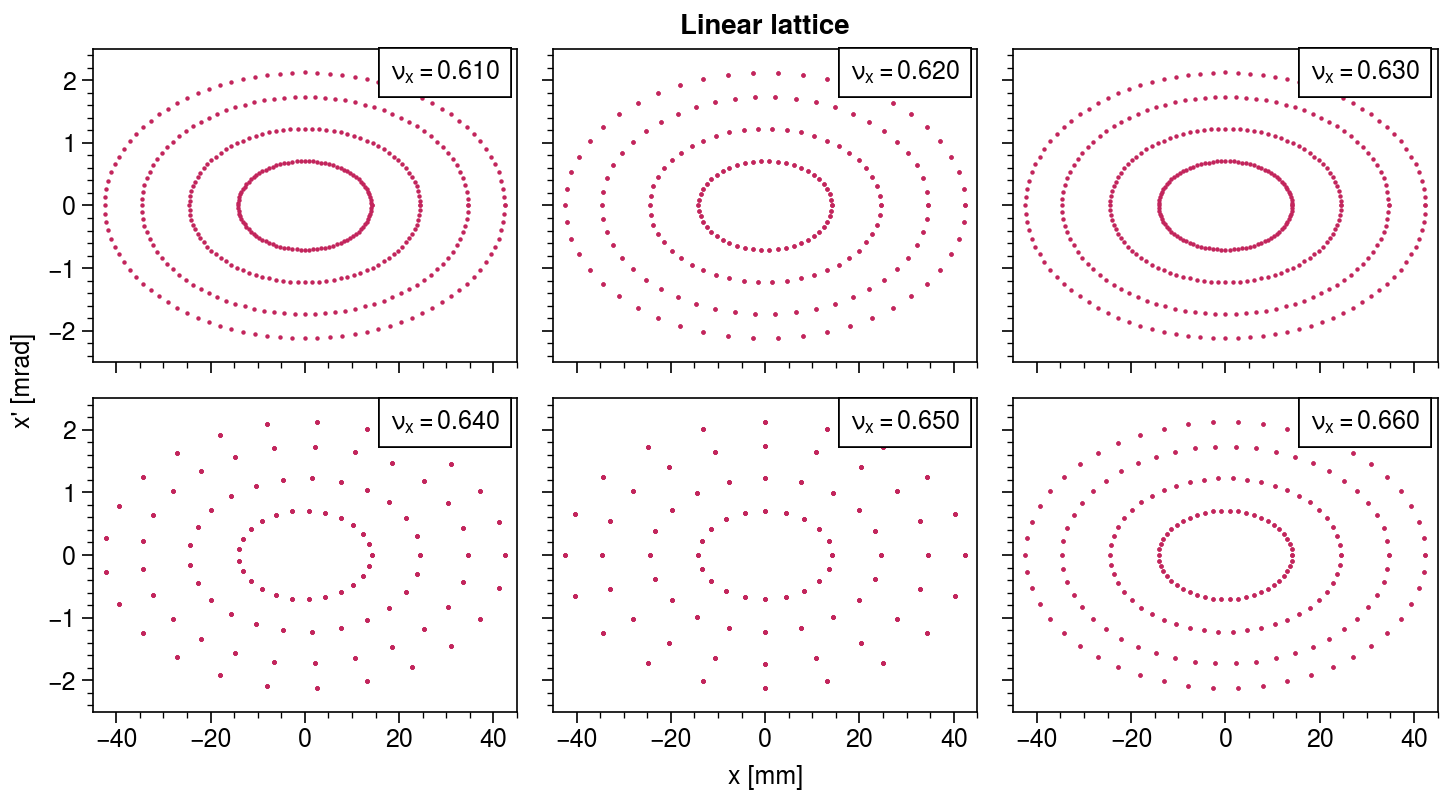

In [10]:
tunes_x = np.linspace(0.61, 0.66, 6)
tune_y = 0.518
emittances = 1e-6 * np.array([10, 30, 60, 90])
nturns = 100

axes = compare_traj(tunes_x, tune_y, emittances, nturns)
axes.format(suptitle='Linear lattice')

Now turn on the sextupole magnet.

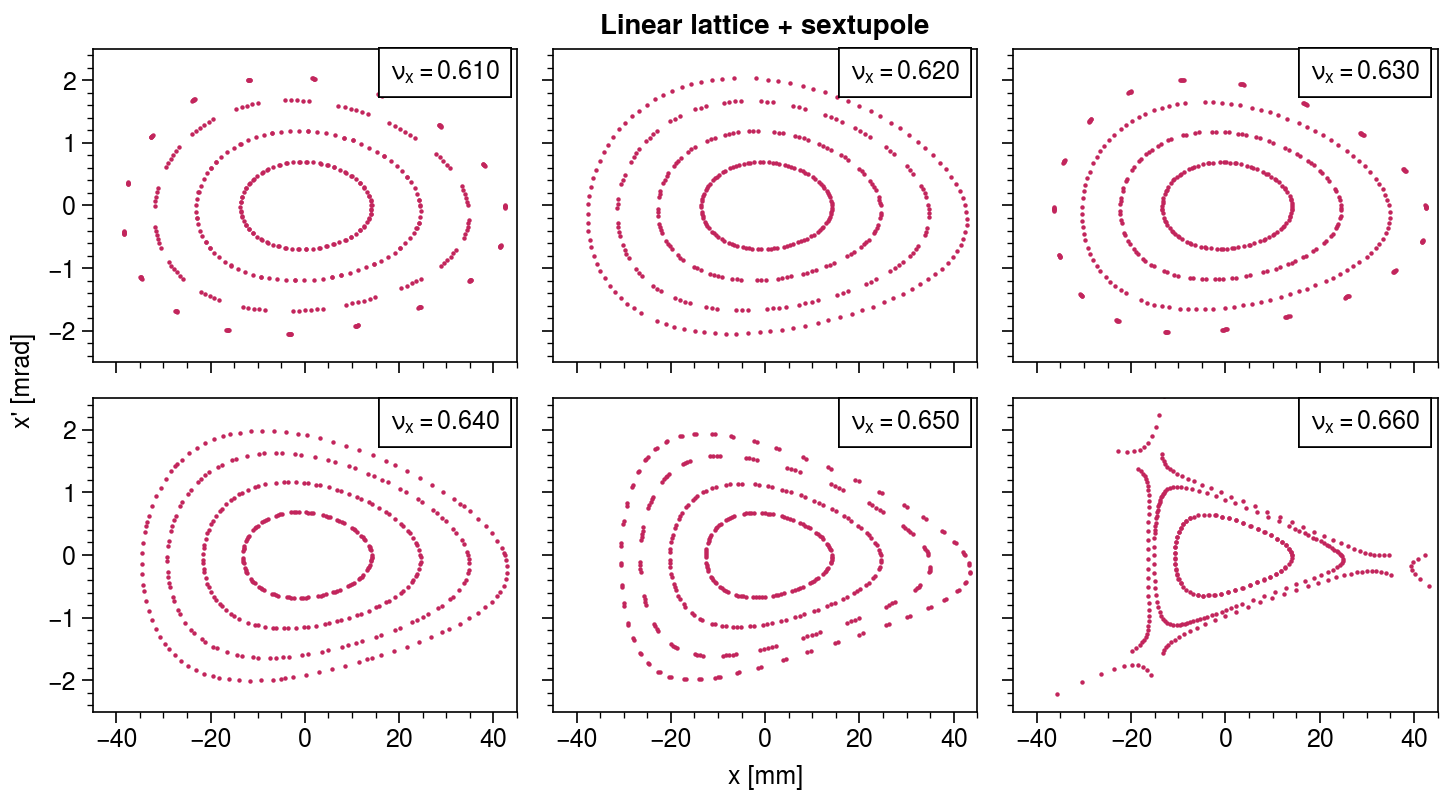

In [11]:
axes = compare_traj(tunes_x, tune_y, emittances, nturns, multipole)
axes.format(suptitle='Linear lattice + sextupole')

The initially elliptical orbits are morphed into a triangular shape as the tune approaches the resonance condition, and some of the larger orbits become unstable. It turns out that by looking at the Hamiltonian you can find a triangular region defining a *separatrix* between stable and unstable motion. Particles inside the triangle will oscillate forever, particles at the corner of the triangle are at unstable equilibrium points, and particles outside the triangle will eventually stream outward from the corners. This is easier to see by tracking a bunch of particles. The interesting stuff will be in the horizontal plane, but I'll plot the vertical plane as well for comparison.

In [12]:
lattice = create_lattice(0.66, tune_y, multipole)
X = lattice.get_matched_bunch()
coords, frac_lost = track_bunch(X, lattice, nturns=50)
animate_phase_space(coords, frac_lost)

The triangular region of stability is clearly visible at the end of 50 turns. Interestingly, the third order resonance can be used to extract a beam from an accelerator at a much slower rate than normal. To do this, the strength and spacing of sextupole magnets must be carefully chosen to control the shape and orientation of the stability triangle, then tune is slowly moved closer to the 1/3 integer resonance value. The result is that the triangle shrinks as the stable phase space area decreases, and that more and more particles will find themselves in the unstable area and eventually stream out along the vertices.

### Integer resonance 

The sextupole should also excite the integer resonance.

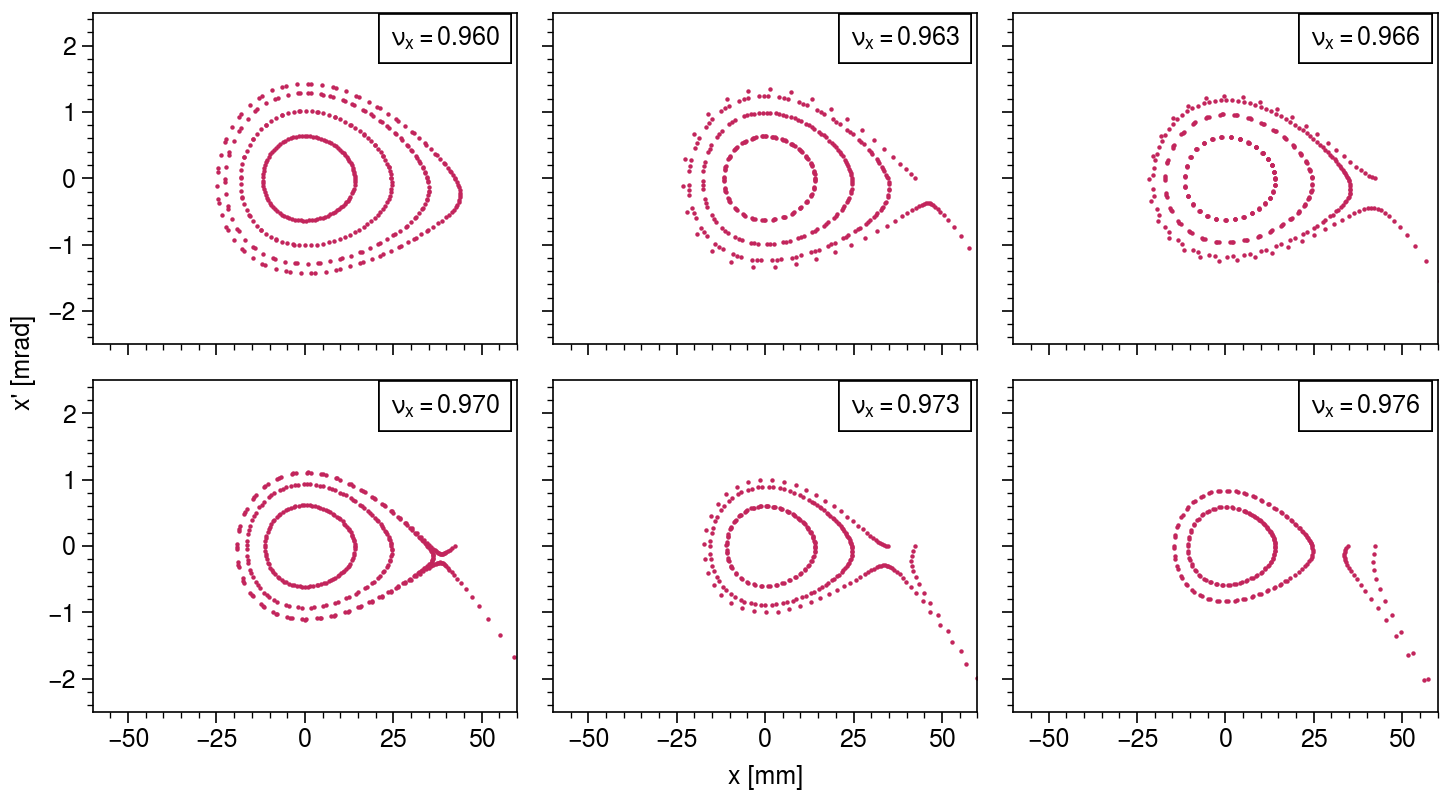

In [13]:
compare_traj(np.linspace(0.96, 0.976, 6), tune_y, emittances, nturns, multipole, limits=(60, 2.5));

In [14]:
lattice = create_lattice(0.99, 0.18, multipole)
animate_phase_space(*track_bunch(X, lattice, nturns=75))

Cool pattern! The separatrix is now shaped like a tear drop. It looks like it's evolving more slowly because the tune is close to an integer, so the particles almost return to the same location in phase space after a turn.

### Higher order resonances

There are also higher order resonances which a sextupole can drive. You can actually find fourth and fifth order resonances if you perform perturbation theory up to second order (at least that's what I'm told in a textbook... I'd like to avoid carrying out such a procedure). Do these show up using our mapping equations? They are expected to be weaker, so we'll double the sextupole strength.

In [15]:
emittances = 1e-6 * np.array([1, 2, 7, 10, 25, 50, 100, 150, 200, 250, 350])
compare_traj(np.linspace(0.7496, 0.798, 6), 0.23, emittances, 1000, Multipole(3, 1.0),
             limits=(150, 6), s=0.1);

These are really interesting plots. The tune near 0.75 (it's actually 0.7496) is exciting a fourth order resonance, while the tune near 0.8 is exciting a fifth order resonance. In all the plots, the low amplitude orbits are stable ellipses. We then see the behavior change as the amplitude is increased, with the particle jumping between distinct "islands". Eventually the trajectories once again form closed loops, but in deformed shapes. The motion is unstable at even larger amplitudes. Understanding exactly *why* the the plots look like they do would take more work.

In [1]:
#hide
# To do: add a section describing Nick's experimental work featuring heatmap of losses vs x and y tune.

## Conclusion

This post outlined the theory of nonlinear resonances driven by magnetic multipoles. The effect of a sextupole-driven resonance on the phase space trajectory was then examined using mapping equations. Taking the time to write down the steps which lead to Eq. (20), an equation which is often referenced in accelerator physics, was a rewarding experience and helped make the topic less mysterious to me (although I'm no expert). Here are a number of helpful references:
* Lectures
    * S. Lund, [*Transverse Particle Resonances
with Application to Circular Accelerators*](https://people.nscl.msu.edu/~lund/uspas/bpisc_2020/lec_set_04/tpr.pdf)
    * E. Prebys, [*Resonances and Coupling*](https://home.fnal.gov/~prebys/misc/uspas_2018/Lectures/10-Resonances%20and%20Coupling.pdf)
* Textbooks
    * D. Edwards and M. Syphers, [*An introduction to the Physics of High Energy Accelerators*](https://www.amazon.com/Introduction-Physics-High-Energy-Accelerators/dp/0471551635)
    * H. Wiedemann, [*Particle Accelerator Physics*](https://www.springer.com/gp/book/9783319183169)
    * S. Y. Lee, [*Accelerator Physics*](https://www.amazon.com/Accelerator-Physics-Fourth-S-Lee/dp/9813274786)
    * L. Reichl, [*The Transition to Chaos — Conservative Classical Systems and Quantum Manifestations*](https://www.springer.com/gp/book/9780387987880)
    * J. Taylor, [*Classical Mechanics*](https://www.amazon.com/Classical-Mechanics-John-R-Taylor/dp/189138922X)
    * H. Goldstein, [*Classical Mechanics*](https://www.amazon.com/Classical-Mechanics-3rd-Herbert-Goldstein/dp/0201657023)